In [38]:
import duckdb
import wandb

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error



In [ ]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%config SqlMagic.named_parameters=True

%sql duckdb:///cfb.db

wandb.login()

In [ ]:
%%jupysql df <<
SELECT 
	games.season,
	games.week,
	plays.game_id,
	plays.id as play_id,
	next_play.id as next_play_id,
	plays.play_type,
	next_play.play_type as next_play_type,
	plays.offense,
	next_play.offense,
	CASE 
		WHEN next_play.id is null then 0
		WHEN plays.offense = next_play.offense and next_play.play_type in ('Passing Touchdown','Rushing Touchdown') then 7
		WHEN plays.offense != next_play.offense and next_play.play_type in ('Passing Touchdown','Rushing Touchdown') then -7
		WHEN plays.offense = next_play.offense and next_play.play_type  in ('Field Goal Good') then 3
		WHEN plays.offense != next_play.offense and next_play.play_type  in ('Field Goal Good') then -3
		WHEN plays.offense = next_play.offense  and next_play.play_type in ('Safety') then -2
		WHEN plays.offense != next_play.offense  and next_play.play_type in ('Safety') then 2
		WHEN plays.offense = next_play.offense  and next_play.play_type  in ('Defensive 2pt Conversion') then -2
		WHEN plays.offense != next_play.offense  and next_play.play_type  in ('Defensive 2pt Conversion') then 2
		WHEN plays.offense  = next_play.offense  and next_play.play_type  in ('Fumble Return Touchdown','Blocked Field Goal Touchdown',
																			  'Blocked Punt Touchdown','Missed Field Goal Return Touchdown',
																			  'Interception Return Touchdown') then -7
		WHEN plays.offense != next_play.offense  and next_play.play_type  in ('Fumble Return Touchdown','Blocked Field Goal Touchdown',
																			  'Blocked Punt Touchdown','Missed Field Goal Return Touchdown',
																			  'Interception Return Touchdown') then 7
		WHEN plays.offense = next_play.offense and next_play.play_type in ('Kickoff Return Touchdown','Punt Return Touchdown') then 7
		WHEN plays.offense != next_play.offense and next_play.play_type in ('Kickoff Return Touchdown','Punt Return Touchdown') then -7
	END AS next_points,
	plays.down,
	plays.distance,
	plays.yards_to_goal,
	plays.period,
	plays.period_seconds_remaining,
	plays.offense_score - plays.defense_score as point_dif
FROM main.stg_plays as plays
INNER JOIN main.games on plays.game_id  = games.id
ASOF LEFT JOIN main.stg_plays as next_play ON
	plays.game_id = next_play.game_id 
	and next_play.id >= plays.id 
	--and next_play.drive_id = plays.drive_id
	and next_play.play_type in ('Field Goal Good','Defensive 2pt Conversion','Fumble Return Touchdown',
									'Passing Touchdown','Blocked Field Goal Touchdown','Blocked Punt Touchdown',
									'Rushing Touchdown','Missed Field Goal Return Touchdown','Interception Return Touchdown',
									'Kickoff Return Touchdown','Punt Return Touchdown','Safety')
where (plays.is_rush = 1 or plays.is_pass = 1)
order by season, week
--limit 100

In [ ]:
df.head()

In [ ]:
sweep_config = {
    "method": "random",
    "metric": {
        "name": "rmse",
        "goal": "minimize"
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [3, 6, 9, 12]
        },
        "learning_rate": {
            "values": [0.1, 0.05, 0.2]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="cfb-ep-model")

In [ ]:
train_df = df[df['season'] < 2022]
valid_df = df[df['season'] == 2022]

In [ ]:
len(train_df), len(valid_df)

In [ ]:
features = ['down','distance','yards_to_goal','period','period_seconds_remaining','point_dif']

X_train = train_df[features]
X_valid = valid_df[features]

y_train = train_df['next_points']
y_valid = valid_df['next_points']

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [ ]:
def train():
    config_defaults = {
        "booster": "gbtree",
        "max_depth": 3,
        "learning_rate": 0.1,
        "subsample": 1,
        "seed": 1234,
        "text_size": 0.33,
    }
    
    wandb.init(config=config_defaults)
    config = wandb.config
    
    model = XGBRegressor(booster=config.booster, max_depth=config.max_depth, 
                         learning_rate=config.learning_rate, subsample=config.subsample)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    print(f"rmse: {rmse}")
    wandb.log({"rmse": rmse})

In [ ]:
wandb.agent(sweep_id, train, count=25)

In [ ]:
api = wandb.Api()
sweep = api.sweep(f"brianlawrence2/cfb-ep-model/sweeps/5aoackjg")
sweep.best_run()

In [ ]:
model_final = XGBRegressor(booster='gbtree',max_depth=6,learning_rate=0.1,subsample=1)
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_valid)

In [ ]:
valid_df['pred'] = y_pred
valid_df.tail()

In [40]:
valid_df[['offense','pred']].groupby('offense').mean('pred').sort_values(by='pred', ascending=False).head(25)

,pred
offense,
Georgia,3.154079
Ferris State,3.108606
North Central,3.084723
Sacramento State,3.012046
Montana State,2.966698
Incarnate Word,2.915334
Florida State,2.864934
Tennessee,2.842016
Ohio State,2.823695


In [41]:
valid_df[['yards_to_goal','pred']].groupby('yards_to_goal').mean('pred')

,pred
yards_to_goal,
0,2.002086
1,6.003407
2,5.885095
3,5.462152
4,5.366085
...,...
96,-0.571660
97,-0.656952
98,-0.640694


ValueError: plot kind scatter can only be used for data frames

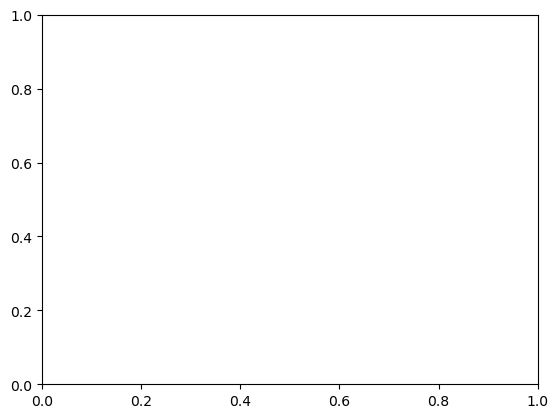

In [48]:
fig, ax = plt.subplots()
valid_df.groupby(['yards_to_goal'])['pred'].mean().plot(kind='scatter')